Iteration 1/100 - Best Combined Score: 27.3075
Iteration 2/100 - Best Combined Score: 27.3075
Iteration 3/100 - Best Combined Score: 27.4331
Iteration 4/100 - Best Combined Score: 27.4331
Iteration 5/100 - Best Combined Score: 27.4331
Iteration 6/100 - Best Combined Score: 27.6792
Iteration 7/100 - Best Combined Score: 27.6792
Iteration 8/100 - Best Combined Score: 27.6792
Iteration 9/100 - Best Combined Score: 27.6792
Iteration 10/100 - Best Combined Score: 27.6792
Iteration 11/100 - Best Combined Score: 27.6890
Iteration 12/100 - Best Combined Score: 27.6890
Iteration 13/100 - Best Combined Score: 27.6890
Iteration 14/100 - Best Combined Score: 27.7114
Iteration 15/100 - Best Combined Score: 27.7114
Iteration 16/100 - Best Combined Score: 27.7114
Iteration 17/100 - Best Combined Score: 27.7114
Iteration 18/100 - Best Combined Score: 27.7114
Iteration 19/100 - Best Combined Score: 27.7114
Iteration 20/100 - Best Combined Score: 27.7114
Iteration 21/100 - Best Combined Score: 27.7114
I

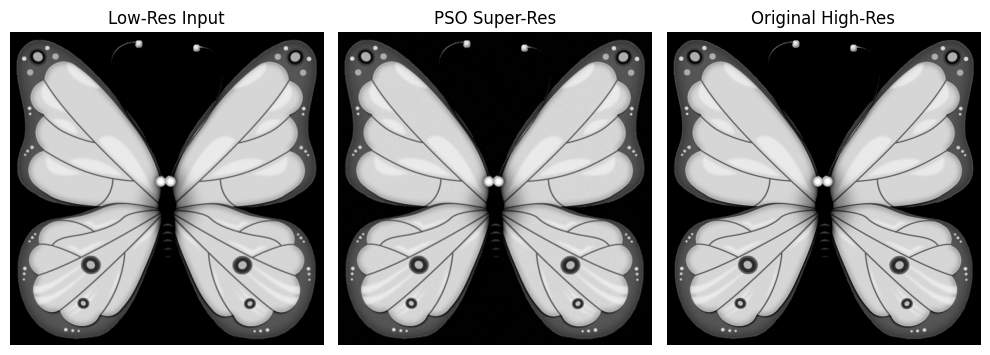

In [1]:
import numpy as np
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# ----- Parameters -----
NUM_PARTICLES = 30
NUM_ITER = 100
W = 0.5
C1 = 1.5
C2 = 1.5

# ----- Load and Downscale Image -----
def load_image(path, scale=2):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    lr_img = cv2.resize(img, (img.shape[1] // scale, img.shape[0] // scale), interpolation=cv2.INTER_AREA).astype(np.float32)
    return img, lr_img

# ----- Fitness Function: Combine PSNR and SSIM -----
def compute_fitness(candidate_hr, target_lr, scale):
    downscaled = cv2.resize(candidate_hr, (target_lr.shape[1], target_lr.shape[0]), interpolation=cv2.INTER_AREA)
    psnr_score = psnr(target_lr, downscaled, data_range=255)
    ssim_score = ssim(target_lr, downscaled, data_range=255)
    return -(0.7 * psnr_score + 0.3 * ssim_score)

# ----- PSO Algorithm -----
def pso_super_resolution(lr_img, hr_shape, scale):
    dim = hr_shape[0] * hr_shape[1]

    # Start from bicubic interpolation
    bicubic_hr = cv2.resize(lr_img, (hr_shape[1], hr_shape[0]), interpolation=cv2.INTER_CUBIC).astype(np.float32)
    particles = np.stack([bicubic_hr.flatten()] * NUM_PARTICLES).astype(np.float32)
    particles += np.random.randn(*particles.shape) * 5  # Add small noise

    velocities = np.random.randn(NUM_PARTICLES, dim)

    pbest = particles.copy()
    pbest_scores = np.array([compute_fitness(p.reshape(hr_shape), lr_img, scale) for p in pbest])
    gbest = pbest[np.argmin(pbest_scores)]

    for iter in range(NUM_ITER):
        for i in range(NUM_PARTICLES):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)

            velocities[i] = (
                W * velocities[i] +
                C1 * r1 * (pbest[i] - particles[i]) +
                C2 * r2 * (gbest - particles[i])
            )
            particles[i] += velocities[i]
            particles[i] = np.clip(particles[i], 0, 255)

            fitness = compute_fitness(particles[i].reshape(hr_shape), lr_img, scale)
            if fitness < pbest_scores[i]:
                pbest[i] = particles[i]
                pbest_scores[i] = fitness

        gbest = pbest[np.argmin(pbest_scores)]
        print(f"Iteration {iter+1}/{NUM_ITER} - Best Combined Score: {-min(pbest_scores):.4f}")

    return gbest.reshape(hr_shape)

# ----- Main -----
if __name__ == "__main__":
    scale = 2
    hr_original, lr_image = load_image("/content/pngimg.com - butterfly_PNG999.png", scale)
    hr_shape = hr_original.shape

    sr_image = pso_super_resolution(lr_image, hr_shape, scale)

    final_psnr = psnr(hr_original, sr_image, data_range=255)
    final_ssim = ssim(hr_original, sr_image, data_range=255)

    print(f"\n✅ Final PSNR: {final_psnr:.2f} dB")
    print(f"✅ Final SSIM: {final_ssim:.4f}")

    # ----- Visualization -----
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.title("Low-Res Input")
    plt.imshow(lr_image, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title("PSO Super-Res")
    plt.imshow(sr_image, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title("Original High-Res")
    plt.imshow(hr_original, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
